<a href="https://colab.research.google.com/github/lkhok22/ML-FinalProject-Walmart-Recruiting---Store-Sales-Forecasting/blob/main/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cell 1: Install Required Packages
!pip install prophet pandas numpy scikit-learn mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.4/741.4 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 13.3 MB/s eta 0:00:00


In [5]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import mlflow
import mlflow.prophet
from datetime import datetime
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from google.colab import drive
import zipfile

In [6]:
# Cell 3: Mount Google Drive and Extract Data
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/ML-Final-Project/data.zip'
extract_dir = '/content/data'
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.endswith('.zip'):
            nested_zip_path = os.path.join(root, file)
            with zipfile.ZipFile(nested_zip_path, 'r') as nested_zip:
                nested_zip.extractall(root)
            os.remove(nested_zip_path)
print(os.listdir(extract_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['sampleSubmission.csv', 'test.csv', 'train.csv', 'features.csv', 'stores.csv']


In [7]:
# Cell 4: Load
train_df = pd.read_csv(os.path.join(extract_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(extract_dir, 'test.csv'))
stores_df = pd.read_csv(os.path.join(extract_dir, 'stores.csv'))
features_df = pd.read_csv(os.path.join(extract_dir, 'features.csv'))

In [8]:
# Merge datasets
train_df['Set'] = 'train'
test_df['Set'] = 'test'
test_df['Weekly_Sales'] = np.nan  # placeholder for consistency

combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df = combined_df.merge(stores_df, on='Store', how='left')
combined_df = combined_df.merge(features_df, on=['Store', 'Date'], how='left')

# Convert 'Date' to datetime
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Sort for Prophet
combined_df = combined_df.sort_values(by=['Store', 'Dept', 'Date'])

In [9]:
# Focus on one Store & Dept for now (e.g., Store 1, Dept 1)
store_id = 1
dept_id = 1

store_dept_df = combined_df[(combined_df['Store'] == store_id) & (combined_df['Dept'] == dept_id)]

# Separate train and test
train_data = store_dept_df[store_dept_df['Set'] == 'train']
test_data = store_dept_df[store_dept_df['Set'] == 'test']

# Prepare for Prophet
prophet_df = train_data[['Date', 'Weekly_Sales']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
prophet_df['y'] = prophet_df['y'].fillna(0)  # Prophet does not like NaNs

In [10]:
# Create and fit Prophet model
model = Prophet()
model.fit(prophet_df)

# Create future DataFrame
future_dates = model.make_future_dataframe(periods=len(test_data), freq='W-MON')  # Weekly forecasts

# Forecast
forecast = model.predict(future_dates)

# Merge forecast back with real test data
forecast_result = forecast[['ds', 'yhat']].copy()
forecast_result.columns = ['Date', 'Weekly_Sales_Predicted']

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5m7m9bp8/sn_qilrd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5m7m9bp8/qcm44qet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16947', 'data', 'file=/tmp/tmp5m7m9bp8/sn_qilrd.json', 'init=/tmp/tmp5m7m9bp8/qcm44qet.json', 'output', 'file=/tmp/tmp5m7m9bp8/prophet_modeltq6qoig4/prophet_model-20250716114450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:44:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:44:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


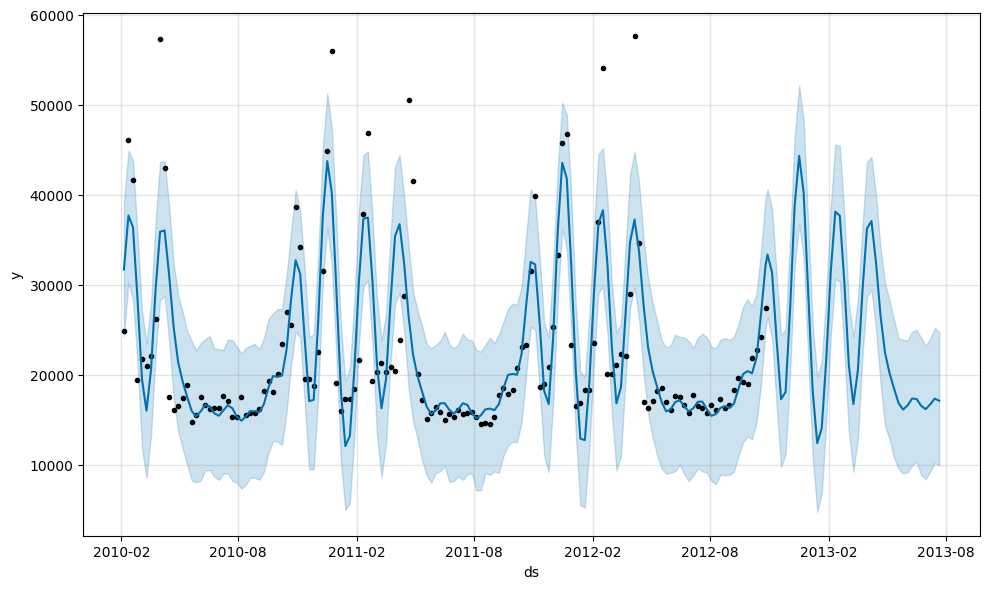

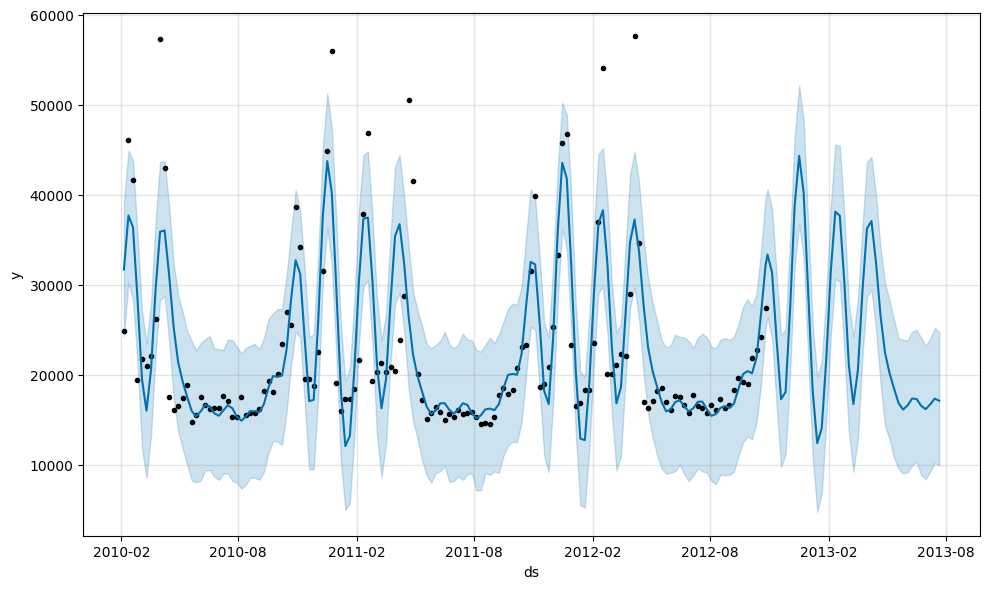

In [11]:
# Plot forecast
model.plot(forecast)

In [12]:
# Evaluate on known validation portion (e.g., last N weeks of training)
val_df = prophet_df.tail(10)
val_pred = model.predict(val_df[['ds']])

print("MAE:", mean_absolute_error(val_df['y'], val_pred['yhat']))
rmse = np.sqrt(mean_squared_error(val_df['y'], val_pred['yhat']))
print("RMSE:", rmse)

MAE: 1560.970451864313
RMSE: 2011.218224401136


In [ ]:
# Make sure 'Date' is datetime
test_df['Date'] = pd.to_datetime(test_df['Date'])
train_df['Date'] = pd.to_datetime(train_df['Date'])

# Rename for Prophet
train_df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)
test_df.rename(columns={'Date': 'ds'}, inplace=True)

# Prepare submission DataFrame
submission = pd.DataFrame()

for (store, dept), group_df in train_df.groupby(['Store', 'Dept']):
    group_train = group_df[['ds', 'y']].copy()

    # Skip groups with fewer than 2 data points
    if group_train['y'].notna().sum() < 2:
        continue

    model = Prophet(yearly_seasonality=True)
    model.fit(group_train)

    group_test = test_df[(test_df['Store'] == store) & (test_df['Dept'] == dept)].copy()
    if group_test.empty:
        continue

    future = group_test[['ds']].copy()
    forecast = model.predict(future)

    group_test['Weekly_Sales'] = forecast['yhat'].values
    submission = pd.concat([submission, group_test[['Store', 'Dept', 'ds', 'Weekly_Sales']]])

In [ ]:
for (store, dept), group_df in train_df.groupby(['Store', 'Dept']):
    group_train = group_df[['ds', 'y']].copy()

    # Skip groups with fewer than 2 data points
    if group_train['y'].notna().sum() < 2:
        continue

    model = Prophet(yearly_seasonality=True)
    model.fit(group_train)

    group_test = test_df[(test_df['Store'] == store) & (test_df['Dept'] == dept)].copy()
    if group_test.empty:
        continue

    future = group_test[['ds']].copy()
    forecast = model.predict(future)

    group_test['Weekly_Sales'] = forecast['yhat'].values
    submission = pd.concat([submission, group_test[['Store', 'Dept', 'ds', 'Weekly_Sales']]])

In [18]:
# Rename 'ds' back to 'Date' to match sample_submission format
submission.rename(columns={'ds': 'Date'}, inplace=True)

# Round predictions if needed
submission['Weekly_Sales'] = submission['Weekly_Sales'].clip(lower=0)  # no negative sales
submission['Weekly_Sales'] = submission['Weekly_Sales'].round(2)

# Ensure correct order (if needed)
submission.sort_values(by=['Store', 'Dept', 'Date'], inplace=True)
# Step 1: Remove duplicates based on Store, Dept, and Date
submission_df = submission.drop_duplicates(subset=['Store', 'Dept', 'Date'], keep='first')

# Step 2: Construct the Id column
submission_df['Id'] = submission_df['Store'].astype(str) + '_' + submission_df['Dept'].astype(str) + '_' + pd.to_datetime(submission_df['Date']).dt.strftime('%Y-%m-%d')

# Step 3: Select required columns and rename Weekly_Sales
submission_df = submission_df[['Id', 'Weekly_Sales']]

# Step 4: Load the sample submission to get all expected Ids
sample_submission = pd.read_csv(os.path.join(extract_dir, 'sampleSubmission.csv'))
expected_ids = sample_submission['Id'].tolist()

# Step 5: Merge to fill missing Ids and impute missing Weekly_Sales
submission_df = pd.DataFrame({'Id': expected_ids}).merge(submission_df, on='Id', how='left')
submission_df['Weekly_Sales'] = submission_df['Weekly_Sales'].fillna(0)  # Impute missing with 0
# Save to CSV
submission_df.to_csv('/content/drive/MyDrive/ML-Final-Project/submission.csv', index=False)

print("✅ Submission file created!")

/tmp/ipython-input-18-3368208750.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['Id'] = submission_df['Store'].astype(str) + '_' + submission_df['Dept'].astype(str) + '_' + pd.to_datetime(submission_df['Date']).dt.strftime('%Y-%m-%d')


✅ Submission file created!
